In [1]:
import os
import re

import tifffile
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mip.gating import get_ideal_window

Loading BokehJS ...

In [2]:
analysis_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_subtyping_paper/gata3_ckit/'
data_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/'

In [3]:
samples = [
    'HT206B1_H1_06252022',
    'HT323B1-H1-08042022'
]

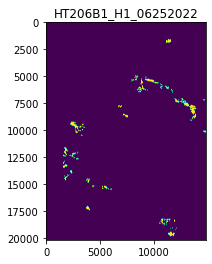

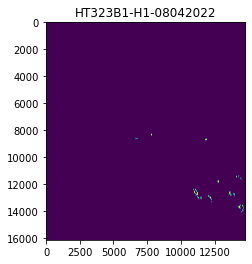

In [4]:
normal_duct_imgs = {s:tifffile.imread(os.path.join(analysis_dir, s, 'normal_duct.tif'))
                   for s in samples}
for s, img in normal_duct_imgs.items():
    
    plt.imshow(img>0)
    plt.title(s)
    plt.show()


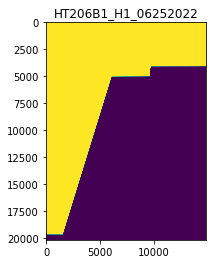

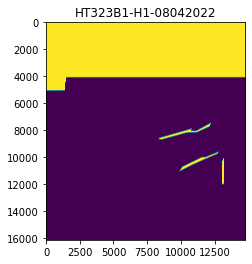

In [5]:
exclude_region_imgs = {s:tifffile.imread(os.path.join(analysis_dir, s, 'exclude.tif'))
                   for s in samples}
for s, img in exclude_region_imgs.items():
    
    plt.imshow(img>0)
    plt.title(s)
    plt.show()


In [6]:
sample_to_adata = {s:sc.read_h5ad(os.path.join(data_dir, s, 'level_4', 'cell_annotation_macro.h5ad'))
                  for s in samples}

sample_to_adata.keys()

dict_keys(['HT206B1_H1_06252022', 'HT323B1-H1-08042022'])

In [7]:
for s, a in sample_to_adata.items():
    mask = [False if exclude_region_imgs[s][int(r), int(c)]>0 else True
            for r, c in zip(a.obs['centroid_row'], a.obs['centroid_col'])]
    sample_to_adata[s] = a[mask]


In [8]:
sample_to_adata['HT206B1_H1_06252022'].shape

(97488, 14)

In [9]:
for s, a in sample_to_adata.items():
    is_tumor, is_duct = [], []
    for r, c, ct in zip(a.obs['centroid_row'], a.obs['centroid_col'], a.obs['cell_type']):
        r, c = int(r), int(c)
        if normal_duct_imgs[s][r, c]:
            is_duct.append(True)
            is_tumor.append(False)
        elif ct == 'Tumor':
            is_tumor.append(True)
            is_duct.append(False)
        else:
            is_tumor.append(False)
            is_duct.append(False)

    a.obs['is_tumor'] = is_tumor
    a.obs['is_duct'] = is_duct   

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  from ipykernel import kernelapp as app


In [10]:
def call_cell(is_tumor, is_duct):
    if is_tumor:
        return 'Tumor'
    if is_duct:
        return 'Normal Duct'
    return 'Other'

for s, a in sample_to_adata.items():
    a.obs['epithelial_classification'] = [call_cell(ist, isd) for ist, isd in zip(a.obs['is_tumor'], a.obs['is_duct'])]

In [11]:
def feature_to_slide(adata, feature, scale=.0005, size=.1):
    x_scale, y_scale = int(max(adata.obs['centroid_col']) * scale), int(max(adata.obs['centroid_row']) * scale)
    order = {i:x for i, x in enumerate(sorted(set(adata.obs[feature])))}
    
    if len(order) < 10:
        cmap = sns.color_palette()
    else:
        cmap = sns.color_palette('tab20')
    
    fig, ax = plt.subplots(figsize=(x_scale, y_scale))
    for i, o in order.items():
        f = a[a.obs[feature]==o]
        plt.scatter(f.obs['centroid_col'], f.obs['centroid_row_inverted'], s=size, c=[cmap[i]], label=o)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    

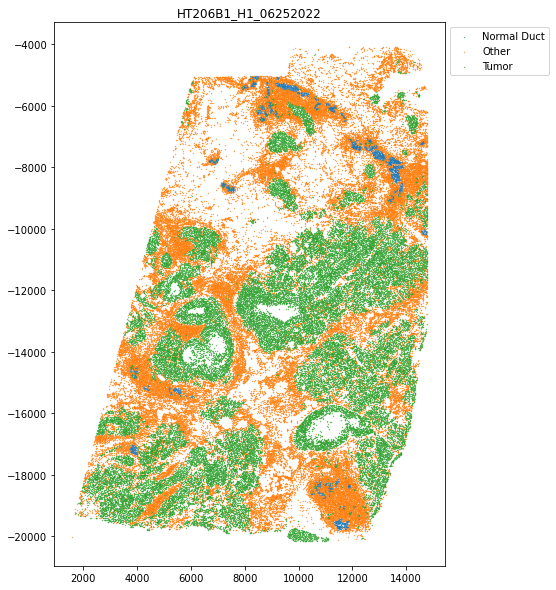

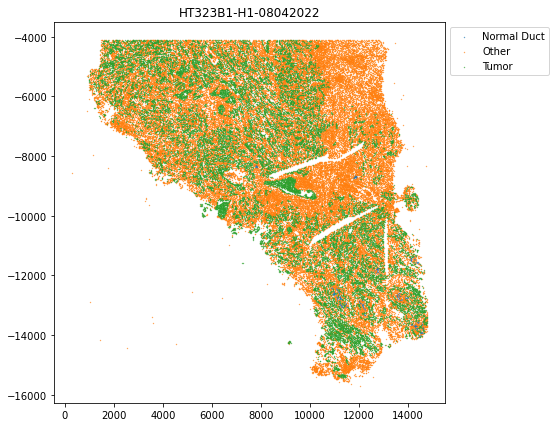

In [12]:
for s, a in sample_to_adata.items():
    feature_to_slide(a, 'epithelial_classification')
    plt.title(s)
    plt.show()

In [13]:
for s, a in sample_to_adata.items():
    duct_region = []
    for r, c in zip(a.obs['centroid_row'], a.obs['centroid_col']):
        r, c = int(r), int(c)
        duct_region.append(str(normal_duct_imgs[s][r, c]))
    a.obs['duct_region_id'] = duct_region

HT206B1_H1_06252022


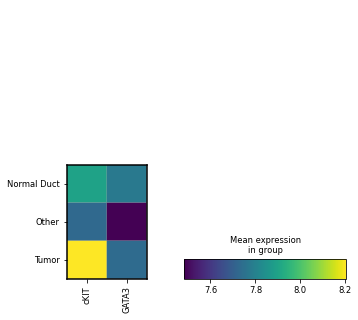

HT323B1-H1-08042022


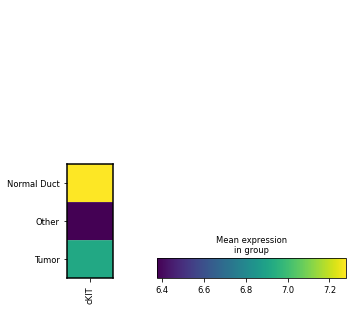

In [14]:
# overall_ratio
to_show = ['cKIT', 'GATA3']
for s, a in sample_to_adata.items():
    print(s)
    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.matrixplot(a, var_names=[v for v in to_show if v in a.raw.var.index],
                     groupby='epithelial_classification', ax=ax)
    plt.show()

HT206B1_H1_06252022


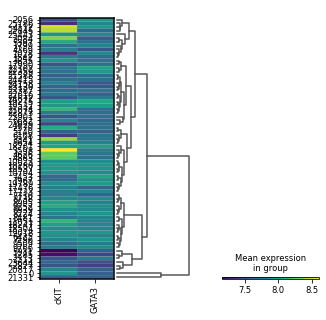

HT323B1-H1-08042022


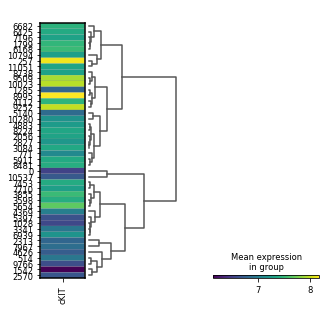

In [16]:
for s, a in sample_to_adata.items():
    print(s)
    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.matrixplot(a, var_names=[v for v in to_show if v in a.raw.var.index],
                     groupby='duct_region_id', ax=ax, dendrogram=True)
    plt.show()

In [25]:
a = next(iter(sample_to_adata.values()))
a

AnnData object with n_obs × n_vars = 97488 × 14
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3e intensity max', 'CD36 intensity max', 'ER intensity max', 'GLUT1 intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'PR intensity max', 'Foxp3 intensity max', 'CK17 intensity max', 'cKIT intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'FGFR3 intensity max', 'GATA3 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min', 'Ki67 intensity min', 'CD68 i

HT206B1_H1_06252022


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


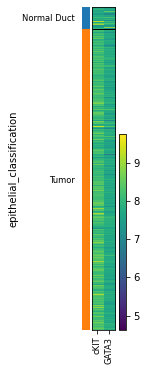

HT323B1-H1-08042022


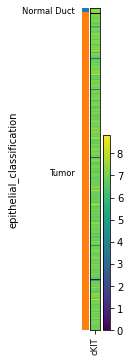

In [26]:
for s, a in sample_to_adata.items():
    print(s)
    if 'epithelial_classification_colors' in a.uns.keys():
        a.uns.pop('epithelial_classification_colors')
    f = a[a.obs['epithelial_classification']!='Other']
    sc.pl.heatmap(f, var_names=[v for v in to_show if v in f.raw.var.index], groupby='epithelial_classification')

HT206B1_H1_06252022


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


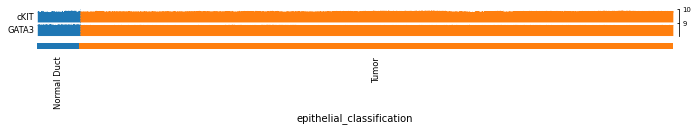

HT323B1-H1-08042022


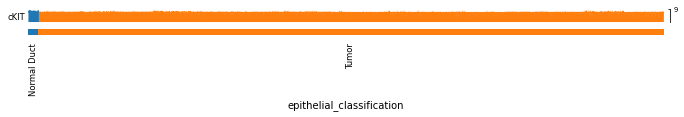

In [29]:
for s, a in sample_to_adata.items():
    print(s)
    f = a[a.obs['epithelial_classification']!='Other']
    sc.pl.tracksplot(f, var_names=[v for v in to_show if v in f.raw.var.index], groupby='epithelial_classification')

HT206B1_H1_06252022


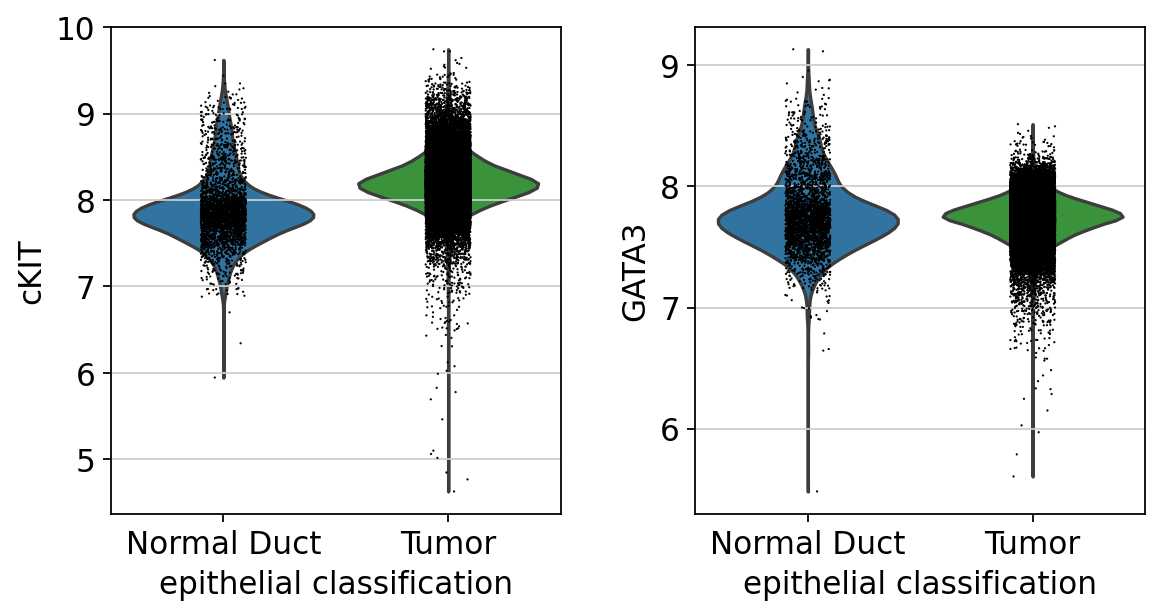

HT323B1-H1-08042022


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


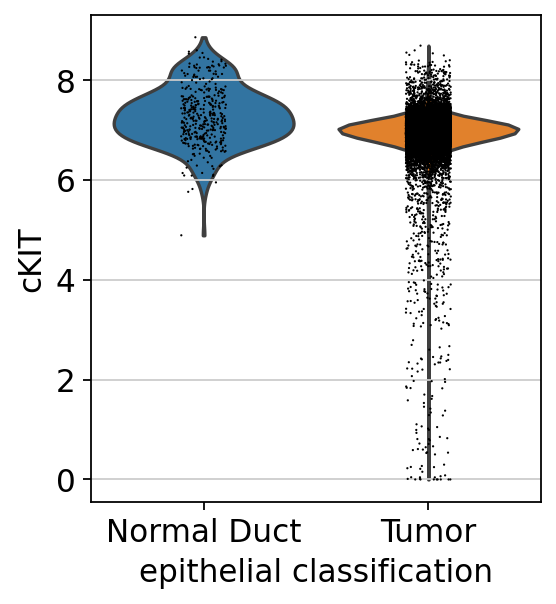

In [83]:
for s, a in sample_to_adata.items():
    print(s)
    f = a[a.obs['epithelial_classification']!='Other']
    sc.pl.violin(f, keys=[v for v in to_show if v in f.raw.var.index], groupby='epithelial_classification')

In [69]:
sc.settings.figdir = os.path.join(analysis_dir, 'figures')

In [52]:
os.path.join(analysis_dir, 'figures')

'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_subtyping_paper/gata3_ckit/figures'

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


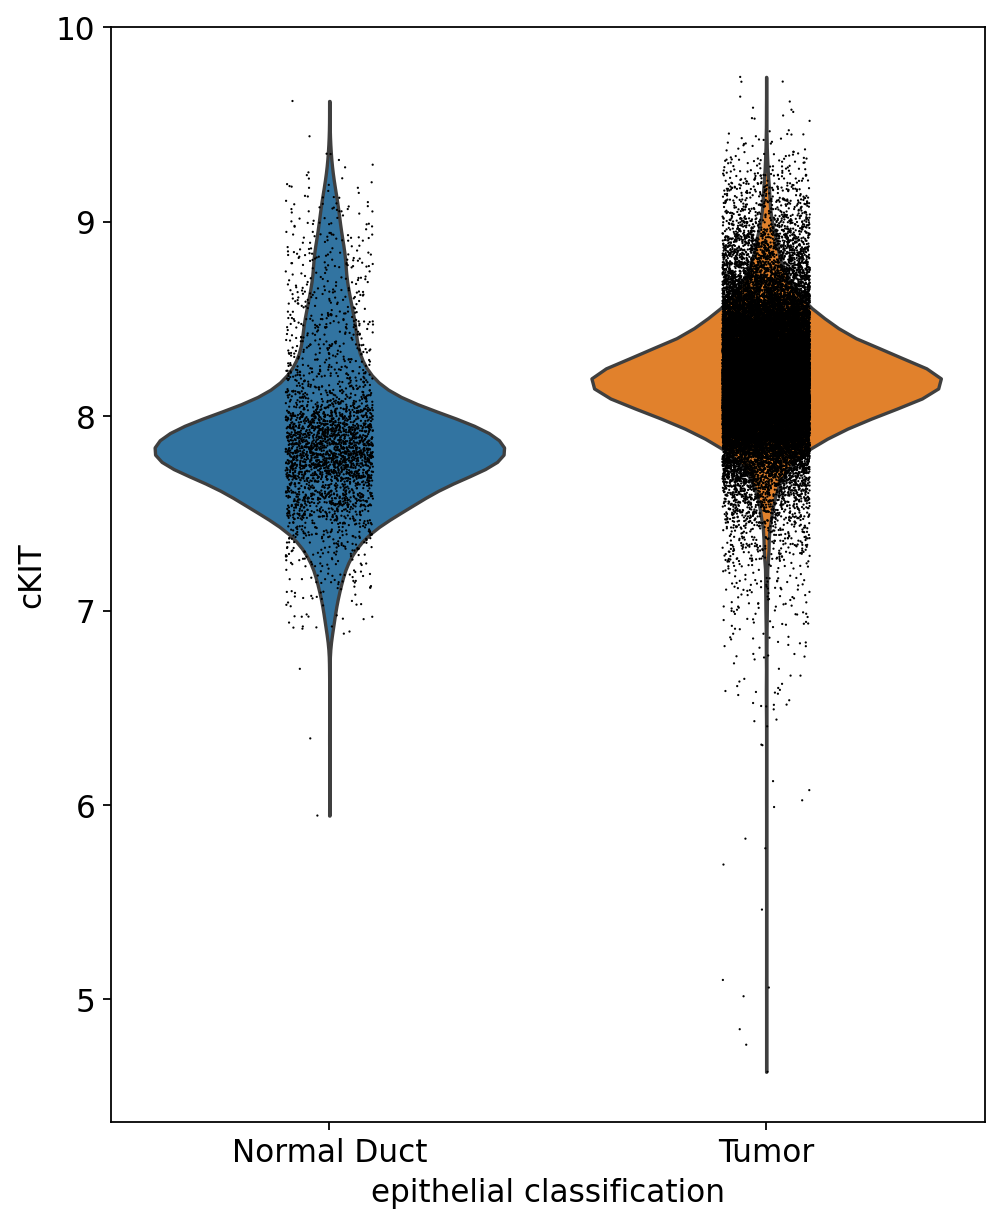

In [70]:
fig, ax = plt.subplots(figsize=(7, 9))
f = sample_to_adata['HT206B1_H1_06252022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
f.uns['epithelial_classification_colors'] = sns.color_palette()[:2]
ax.grid(False)
sc.pl.violin(f, keys=['cKIT'], groupby='epithelial_classification', ax=ax, save='violin_ht206_ckit.png')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


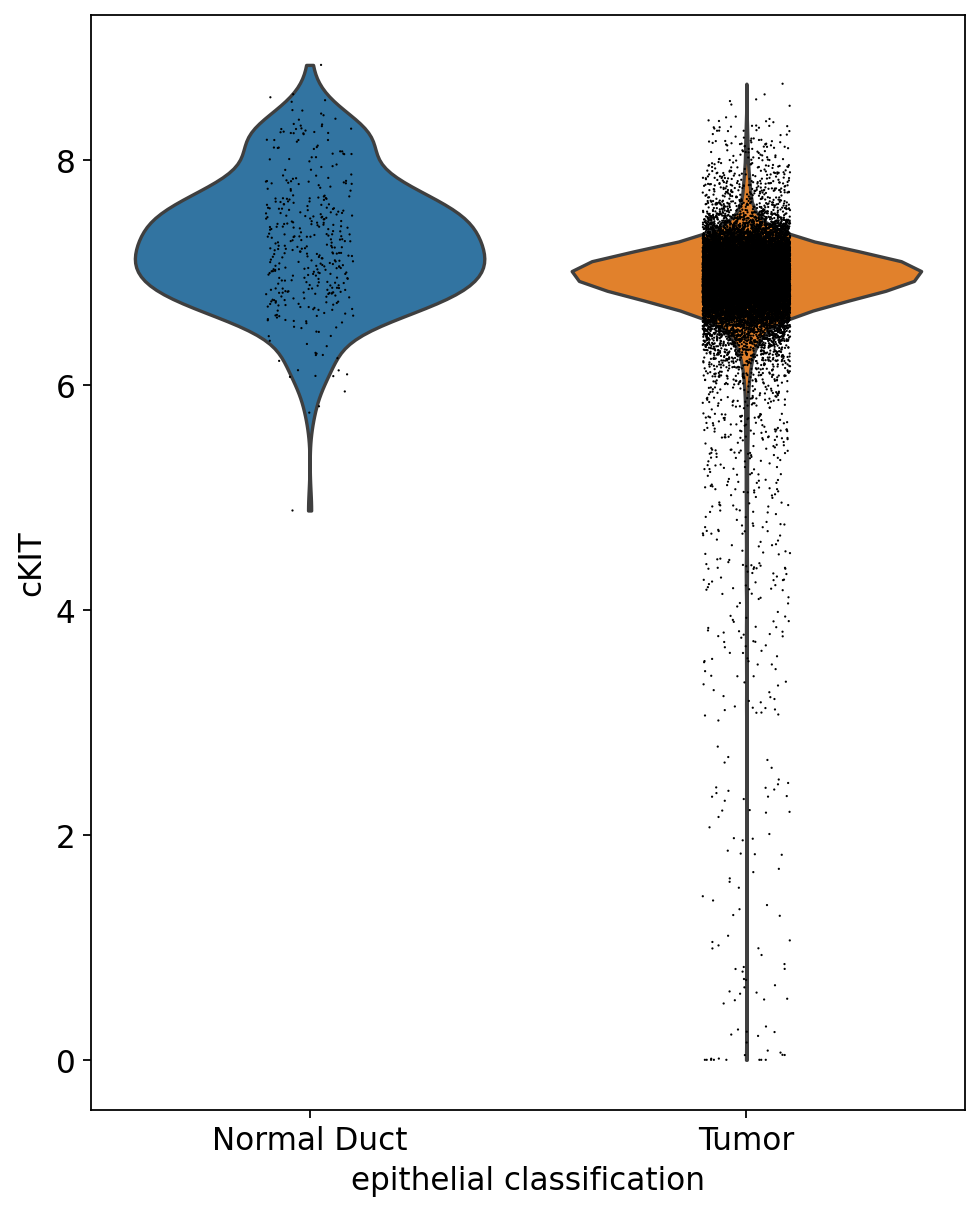

In [71]:
fig, ax = plt.subplots(figsize=(7, 9))
f = sample_to_adata['HT323B1-H1-08042022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
f.uns['epithelial_classification_colors'] = sns.color_palette()[:2]
ax.grid(False)
sc.pl.violin(f, keys=['cKIT'], groupby='epithelial_classification', ax=ax, save='violin_ht323_ckit.png')

In [44]:
a = sample_to_adata['HT206B1_H1_06252022'][sample_to_adata['HT206B1_H1_06252022'].obs['epithelial_classification']!='Other']
b = sample_to_adata['HT323B1-H1-08042022'][sample_to_adata['HT323B1-H1-08042022'].obs['epithelial_classification']!='Other']

source = pd.DataFrame.from_dict({
    'sample': 'HT206B1_H1_06252022',
    'subtype': 'Basal',
    'cell type': a.obs['epithelial_classification'],
    'log(cKIT)': a.raw[:, 'cKIT'].X.flatten(),
    'cKIT': a.raw[:, 'cKIT'].X.flatten(),
})

source = pd.concat((source,
                    pd.DataFrame.from_dict({
                        'sample': 'HT323B1-H1-08042022',
                        'subtype': 'Luminal',
                        'cell type': b.obs['epithelial_classification'],
                        'log(cKIT)': b.raw[:, 'cKIT'].X.flatten()
                    })
), axis=0)

source

,sample,subtype,cell type,log(cKIT)
15398,HT206B1_H1_06252022,Basal,Tumor,7.522305
16459,HT206B1_H1_06252022,Basal,Tumor,7.553051
16550,HT206B1_H1_06252022,Basal,Tumor,7.490337
17231,HT206B1_H1_06252022,Basal,Tumor,7.753099
17383,HT206B1_H1_06252022,Basal,Tumor,7.306876
...,...,...,...,...
108567,HT323B1-H1-08042022,Luminal,Tumor,7.059034
108571,HT323B1-H1-08042022,Luminal,Tumor,6.776829
108573,HT323B1-H1-08042022,Luminal,Tumor,6.725569
108587,HT323B1-H1-08042022,Luminal,Tumor,6.358240


In [82]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

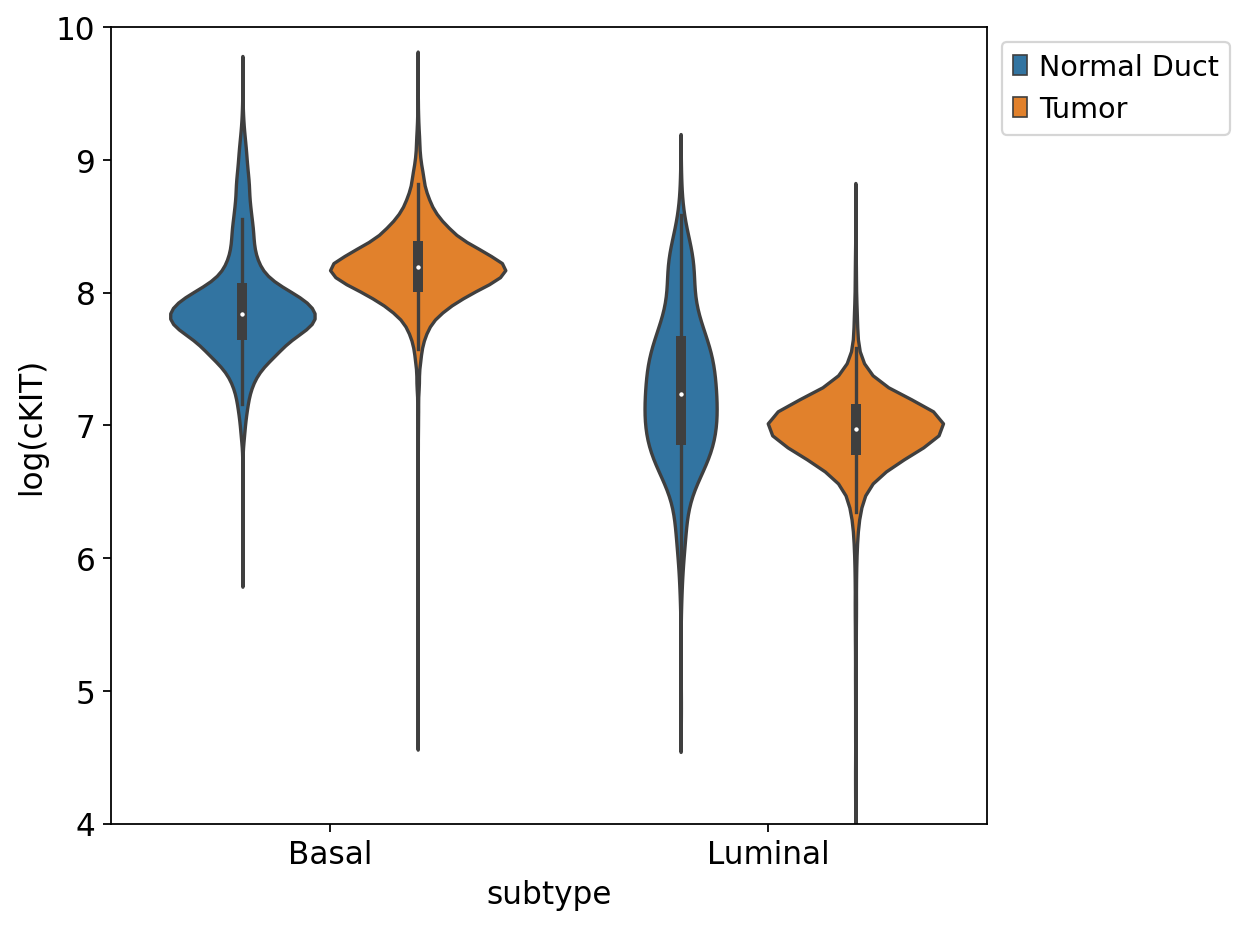

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.violinplot(data=source, x='subtype', y='log(cKIT)', hue='cell type', )
ax.grid(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylim(4, 10)
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'violin_ckit.pdf'))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.violinplot(data=source, x='subtype', y='cKIT', hue='cell type', )
ax.grid(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylim(4, 10)
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'violin_ckit.pdf'))

In [84]:
sample_to_adata.keys()

dict_keys(['HT206B1_H1_06252022', 'HT323B1-H1-08042022'])

In [119]:
sample_to_renorm = {}
for s, a in sample_to_adata.items():
    b = a.copy()
    b.obs['cKIT'] = 2**b.raw[:, 'cKIT'].X.flatten()
    b.obs['cKIT_std'] = np.log1p(b.obs['cKIT'] / np.std(b.obs['cKIT']))
    print(s, np.std(b.obs['cKIT']))
    sample_to_renorm[s] = b

HT206B1_H1_06252022 68.94701385498047
HT323B1-H1-08042022 40.412391662597656


In [120]:
sample_to_renorm['HT206B1_H1_06252022'].obs

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,leiden,cell_type_general,centroid_row_inverted,cell_type,is_tumor,is_duct,epithelial_classification,duct_region_id,cKIT,cKIT_std
cell_id,,,,,,,,,,,,,,,,,,,,,
15398,482,165.095454,4073,13132,4106,13164,4089.485477,13149.300830,0.770800,19354.0,...,41,Epithelial,-4089.485477,Tumor,True,False,Tumor,0,183.839752,1.299208
15413,133,51.006097,4077,13569,4093,13584,4084.390977,13575.067669,0.736156,25138.0,...,32,Stroma,-4084.390977,Noise,False,False,Other,0,151.308044,1.161448
15423,390,117.811183,4075,13226,4104,13252,4089.553846,13237.712821,0.726424,31688.0,...,32,Stroma,-4089.553846,Fibroblast,False,False,Other,0,144.678177,1.130885
15424,533,135.331998,4073,13654,4098,13687,4086.101313,13669.542214,0.727477,34405.0,...,29,Stroma,-4086.101313,Fibroblast,False,False,Other,0,154.703766,1.176748
15428,166,80.047727,4074,13585,4093,13602,4083.018072,13592.975904,0.686755,26030.0,...,29,Stroma,-4083.018072,Fibroblast,False,False,Other,0,96.870934,0.877552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136402,48,32.349242,20149,10223,20157,10236,20152.750000,10230.020833,0.877933,6102.0,...,24,Epithelial,-20152.750000,Tumor,True,False,Tumor,0,632.129028,2.319278
136403,222,73.627417,20150,10913,20160,10942,20155.333333,10927.900901,0.945689,18912.0,...,24,Epithelial,-20155.333333,Tumor,True,False,Tumor,0,489.076111,2.091062
136404,108,59.798990,20152,10212,20160,10236,20156.500000,10223.629630,0.952507,15680.0,...,0,Epithelial,-20156.500000,Tumor,True,False,Tumor,0,513.548706,2.133984


In [121]:
a = sample_to_renorm['HT206B1_H1_06252022'][sample_to_renorm['HT206B1_H1_06252022'].obs['epithelial_classification']!='Other']
b = sample_to_renorm['HT323B1-H1-08042022'][sample_to_renorm['HT323B1-H1-08042022'].obs['epithelial_classification']!='Other']

source = pd.DataFrame.from_dict({
    'sample': 'HT206B1_H1_06252022',
    'subtype': 'Basal',
    'cell type': a.obs['epithelial_classification'],
    'cKIT': a.obs['cKIT'],
    'cKIT_std': a.obs['cKIT_std'],
})

source = pd.concat((source,
                    pd.DataFrame.from_dict({
                        'sample': 'HT323B1-H1-08042022',
                        'subtype': 'Luminal',
                        'cell type': b.obs['epithelial_classification'],
                        'cKIT': b.obs['cKIT'],
                        'cKIT_std': b.obs['cKIT_std']

                    })
), axis=0)

source

,sample,subtype,cell type,cKIT,cKIT_std
15398,HT206B1_H1_06252022,Basal,Tumor,183.839752,1.299208
16459,HT206B1_H1_06252022,Basal,Tumor,187.799713,1.314752
16550,HT206B1_H1_06252022,Basal,Tumor,179.810928,1.283142
17231,HT206B1_H1_06252022,Basal,Tumor,215.732452,1.418026
17383,HT206B1_H1_06252022,Basal,Tumor,158.339371,1.192873
...,...,...,...,...,...
108567,HT323B1-H1-08042022,Luminal,Tumor,133.346329,1.458531
108571,HT323B1-H1-08042022,Luminal,Tumor,109.655075,1.311949
108573,HT323B1-H1-08042022,Luminal,Tumor,105.827354,1.286111
108587,HT323B1-H1-08042022,Luminal,Tumor,82.039093,1.108578


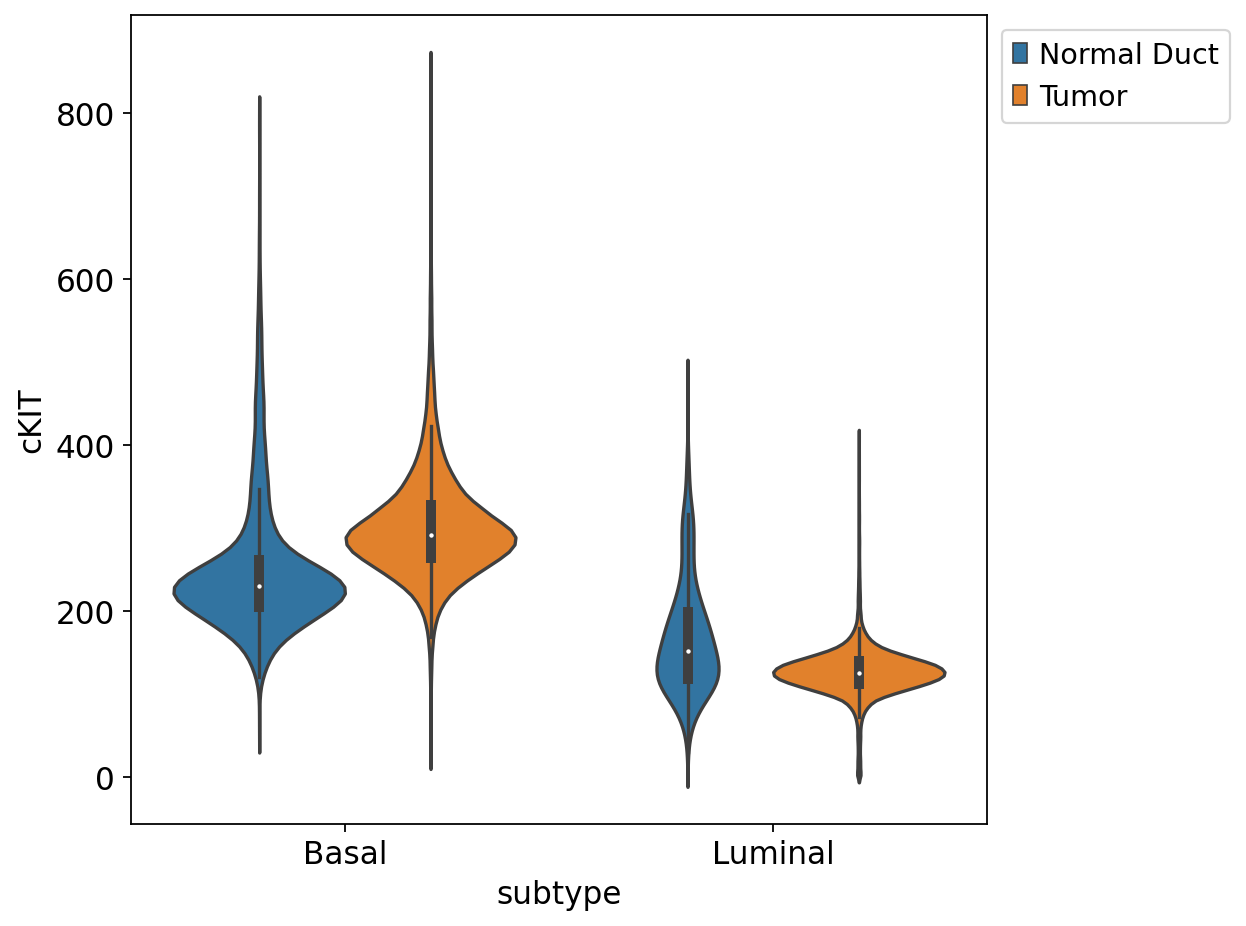

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.violinplot(data=source, x='subtype', y='cKIT', hue='cell type', )
ax.grid(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.ylim(4, 10)
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'violin_ckit.pdf'))

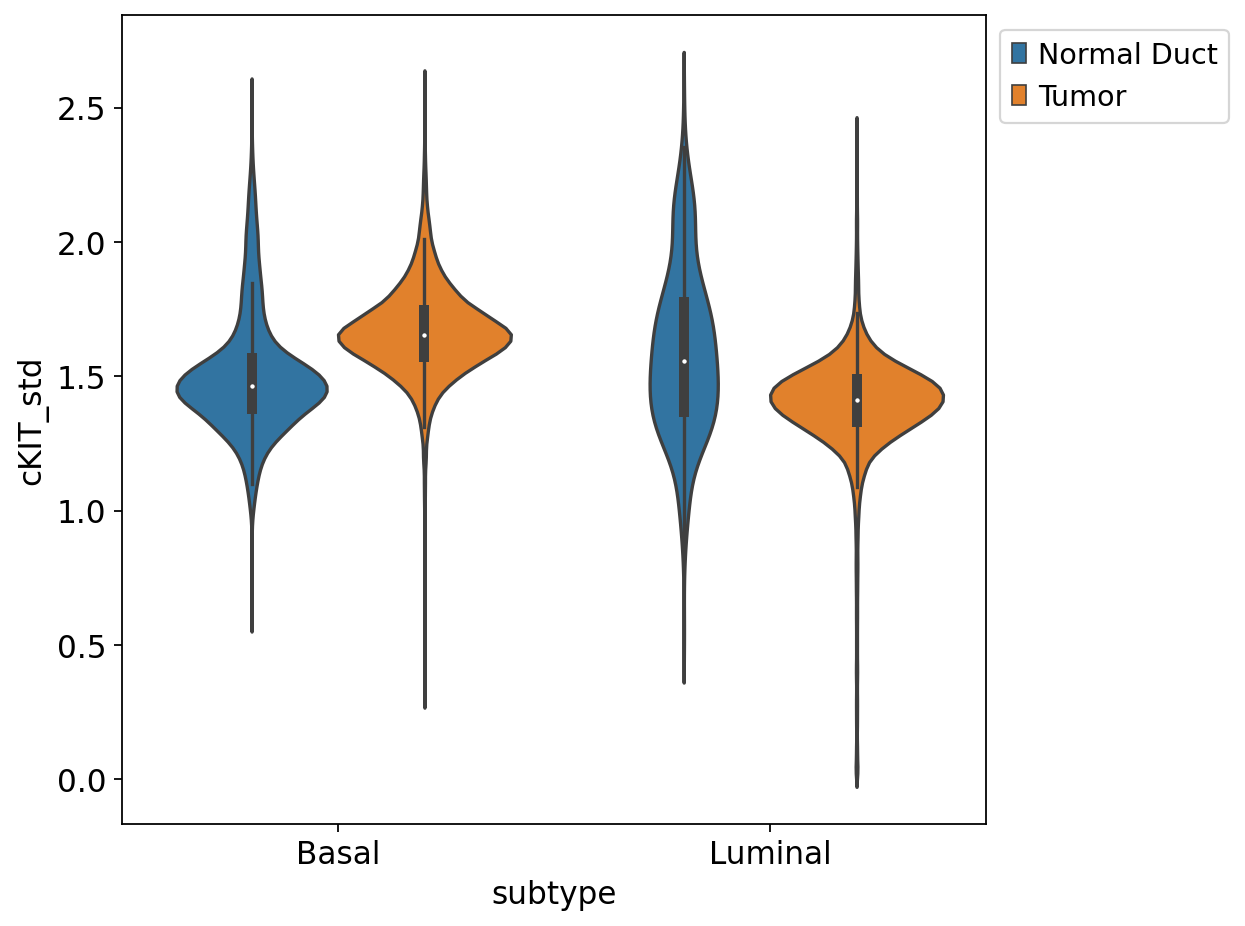

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.violinplot(data=source, x='subtype', y='cKIT_std', hue='cell type', )
ax.grid(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

# plt.ylim(4, 10)
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'violin_ckit.pdf'))

In [124]:
source

,sample,subtype,cell type,cKIT,cKIT_std
15398,HT206B1_H1_06252022,Basal,Tumor,183.839752,1.299208
16459,HT206B1_H1_06252022,Basal,Tumor,187.799713,1.314752
16550,HT206B1_H1_06252022,Basal,Tumor,179.810928,1.283142
17231,HT206B1_H1_06252022,Basal,Tumor,215.732452,1.418026
17383,HT206B1_H1_06252022,Basal,Tumor,158.339371,1.192873
...,...,...,...,...,...
108567,HT323B1-H1-08042022,Luminal,Tumor,133.346329,1.458531
108571,HT323B1-H1-08042022,Luminal,Tumor,109.655075,1.311949
108573,HT323B1-H1-08042022,Luminal,Tumor,105.827354,1.286111
108587,HT323B1-H1-08042022,Luminal,Tumor,82.039093,1.108578


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


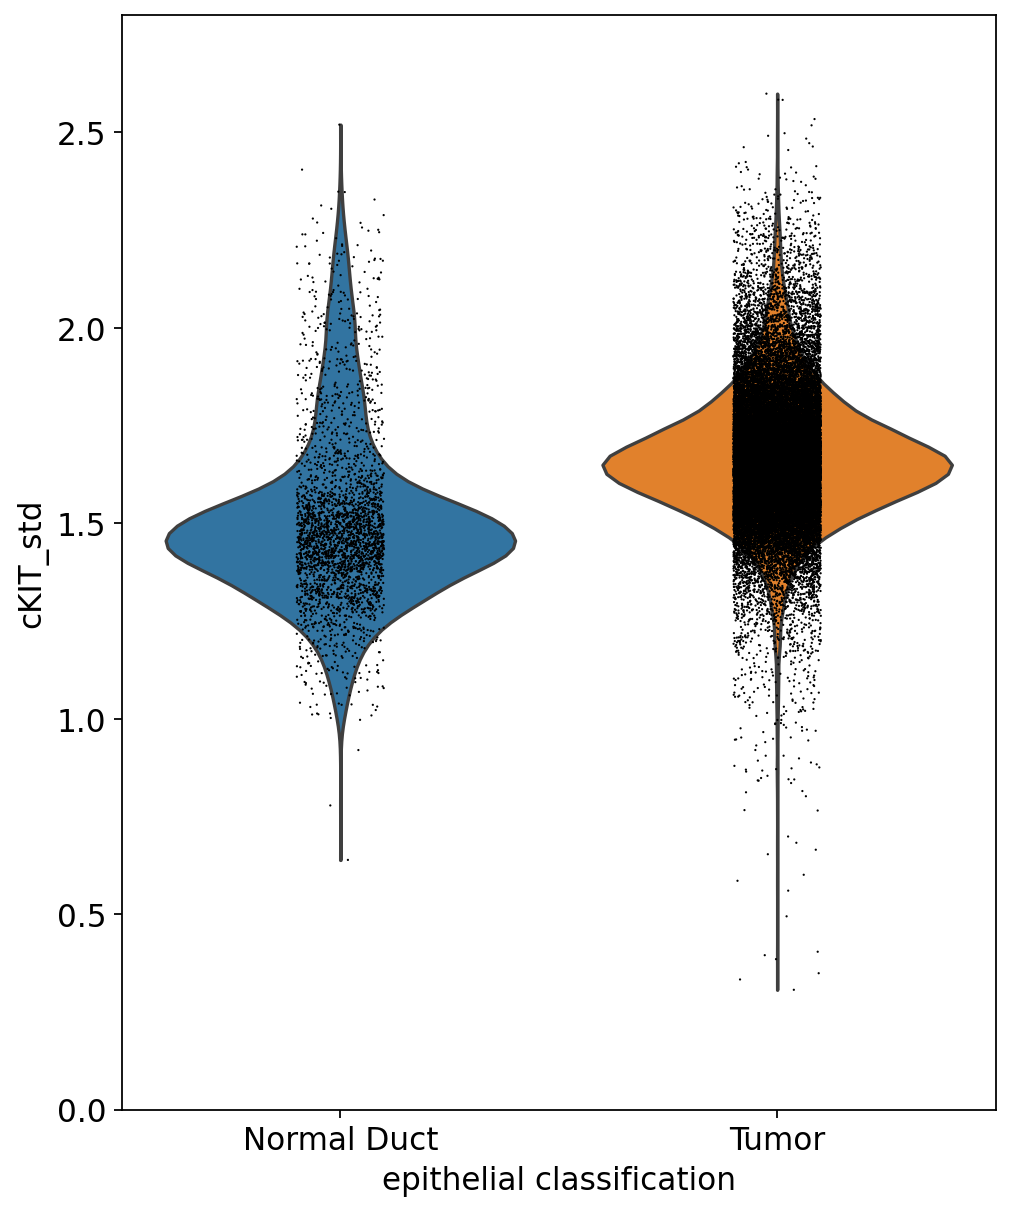

In [133]:
fig, ax = plt.subplots(figsize=(7, 9))
f = sample_to_renorm['HT206B1_H1_06252022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
f.uns['epithelial_classification_colors'] = sns.color_palette()[:2]
ax.grid(False)
ax.set_ylim(0, 2.8)
sc.pl.violin(f, keys=['cKIT_std'], groupby='epithelial_classification', ax=ax, save='violin_ht206_ckit.pdf')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


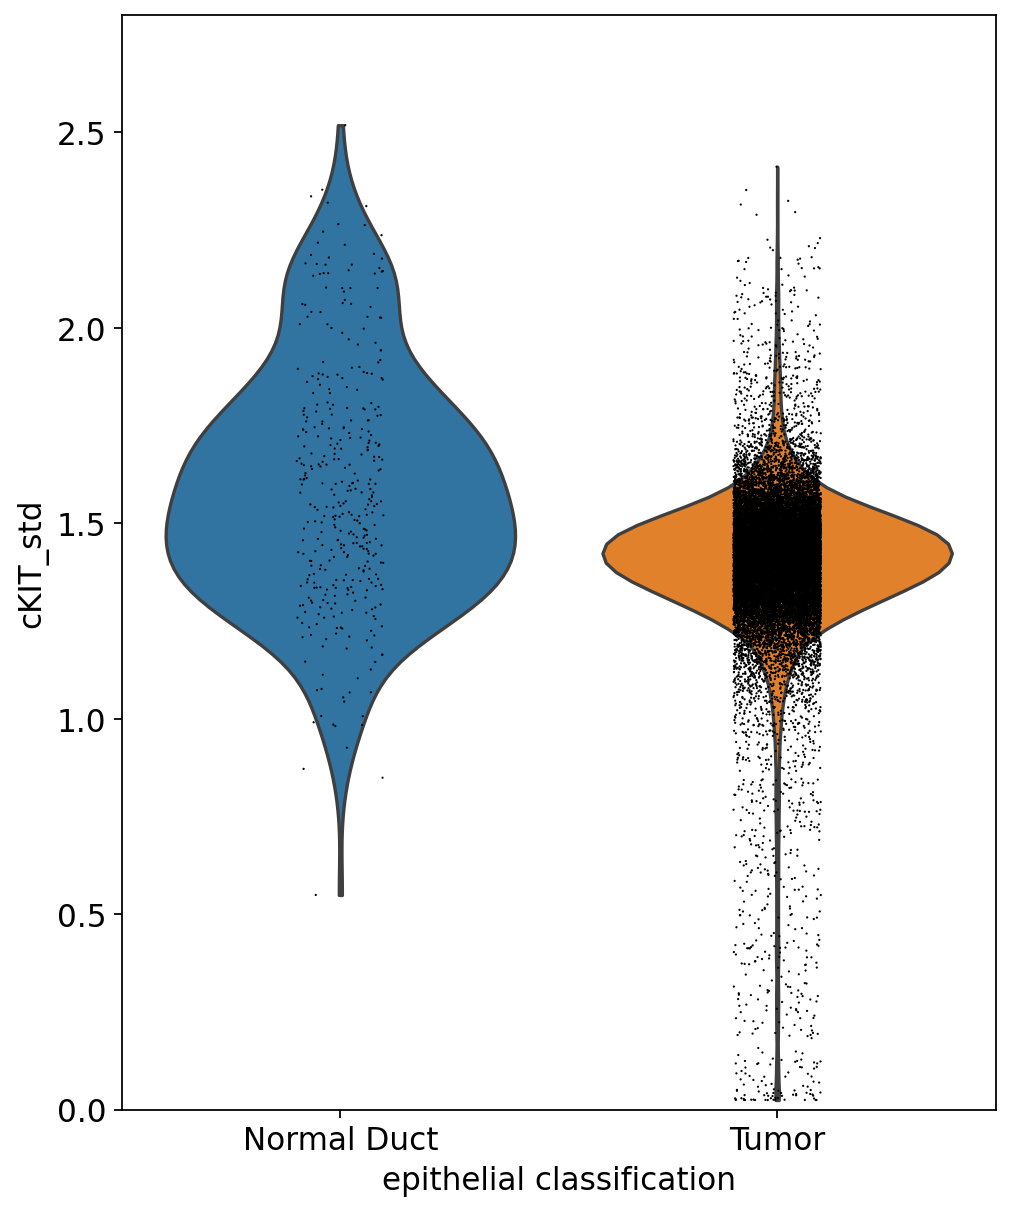

In [132]:
fig, ax = plt.subplots(figsize=(7, 9))
f = sample_to_renorm['HT323B1-H1-08042022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
f.uns['epithelial_classification_colors'] = sns.color_palette()[:2]
ax.grid(False)
ax.set_ylim(0, 2.8)
sc.pl.violin(f, keys=['cKIT_std'], groupby='epithelial_classification', ax=ax, save='violin_ht323_ckit.pdf')

In [134]:
sc.settings.figdir

PosixPath('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_subtyping_paper/gata3_ckit/figures')

In [136]:
f = sample_to_renorm['HT323B1-H1-08042022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
f.obs

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,leiden,cell_type_general,centroid_row_inverted,cell_type,is_tumor,is_duct,epithelial_classification,duct_region_id,cKIT,cKIT_std
CellID,,,,,,,,,,,,,,,,,,,,,
27107,2728,259.728968,4073,4198,4139,4277,4103.163856,4239.457845,0.827604,15147.0,...,10,Epithelial,-4103.163856,Tumor,True,False,Tumor,0,145.701035,1.527220
27146,2046,224.764502,4075,5961,4138,6016,4107.508309,5985.690127,0.645257,7790.0,...,1,Epithelial,-4107.508309,Tumor,True,False,Tumor,0,131.466751,1.447655
27149,796,136.089358,4075,7993,4115,8024,4096.059045,8005.777638,0.813631,13087.0,...,42,Epithelial,-4096.059045,Tumor,True,False,Tumor,0,160.699890,1.604727
27166,765,141.574639,4080,2764,4111,2802,4095.407843,2782.715033,0.478821,11383.0,...,21,Epithelial,-4095.407843,Tumor,True,False,Tumor,0,107.657013,1.298545
27174,1109,138.024387,4076,8787,4120,8829,4100.930568,8805.760144,0.634306,9802.0,...,17,Epithelial,-4100.930568,Tumor,True,False,Tumor,0,135.147903,1.468846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108567,336,100.533009,15379,11184,15399,11213,15388.809524,11200.372024,0.754468,15591.0,...,6,Epithelial,-15388.809524,Tumor,True,False,Tumor,0,133.346329,1.458531
108571,333,74.840620,15387,11409,15406,11436,15396.357357,11421.612613,0.742037,14164.0,...,2,Epithelial,-15396.357357,Tumor,True,False,Tumor,0,109.655075,1.311949
108573,287,74.805087,15391,11261,15411,11286,15400.073171,11273.728223,0.751793,38357.0,...,37,Epithelial,-15400.073171,Tumor,True,False,Tumor,0,105.827354,1.286111


In [138]:
from scipy.stats import ttest_ind

In [139]:
ls = f[f.obs['epithelial_classification']=='Normal Duct'].obs['cKIT_std']
xs = f[f.obs['epithelial_classification']=='Tumor'].obs['cKIT_std']
ttest_ind(ls, xs)

Ttest_indResult(statistic=19.0219714355164, pvalue=4.5881660583550894e-80)

In [140]:
f = sample_to_renorm['HT206B1_H1_06252022'].copy()
f = f[f.obs['epithelial_classification']!='Other']
ls = f[f.obs['epithelial_classification']=='Normal Duct'].obs['cKIT_std']
xs = f[f.obs['epithelial_classification']=='Tumor'].obs['cKIT_std']
ttest_ind(ls, xs)

Ttest_indResult(statistic=-50.589286662878045, pvalue=0.0)